# Data Generation using Modelling and Simulation for Machine Learning





---
## Step 1 & 2: Install and Import Required Libraries

SciPy comes pre-installed on Colab. We also need standard ML and visualization libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint
import warnings
import time

warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    mean_absolute_percentage_error
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

print("All libraries loaded successfully.")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

All libraries loaded successfully.
NumPy version: 2.0.2
Pandas version: 2.2.2


---
## Step 3: Define Simulation Parameters and Their Bounds

Each parameter has a physically meaningful range. These ranges were chosen based on typical engineering values for metal components and common operating environments.

In [2]:
# Define parameter bounds with physical justification
param_bounds = {
    'initial_temp': {
        'lower': 350.0,    # 350 K (~77°C) - warm component
        'upper': 600.0,    # 600 K (~327°C) - very hot component
        'unit': 'K',
        'description': 'Starting temperature of the heated object'
    },
    'ambient_temp': {
        'lower': 280.0,    # 280 K (~7°C) - cold room
        'upper': 320.0,    # 320 K (~47°C) - hot environment
        'unit': 'K',
        'description': 'Temperature of surrounding environment'
    },
    'mass': {
        'lower': 0.1,      # 100 grams
        'upper': 5.0,      # 5 kg
        'unit': 'kg',
        'description': 'Mass of the metal component'
    },
    'specific_heat': {
        'lower': 200.0,    # ~Lead (128) to low alloys
        'upper': 900.0,    # ~Aluminum (897)
        'unit': 'J/(kg·K)',
        'description': 'Specific heat capacity of the material'
    },
    'heat_transfer_coeff': {
        'lower': 5.0,      # Natural convection in air
        'upper': 100.0,    # Forced convection in air
        'unit': 'W/(m²·K)',
        'description': 'Convective heat transfer coefficient'
    },
    'surface_area': {
        'lower': 0.005,    # Small component (~5 cm²)
        'upper': 0.5,      # Larger component (~5000 cm²)
        'unit': 'm²',
        'description': 'Exposed surface area for convection'
    },
    'heat_generation': {
        'lower': 0.0,      # No internal heat
        'upper': 50.0,     # Up to 50 W internal generation
        'unit': 'W',
        'description': 'Internal heat generation rate (e.g., electrical dissipation)'
    },
    'sim_duration': {
        'lower': 60.0,     # 1 minute
        'upper': 3600.0,   # 1 hour
        'unit': 's',
        'description': 'How long the simulation runs'
    }
}

# Display the parameter table
param_df = pd.DataFrame({
    'Parameter': list(param_bounds.keys()),
    'Lower Bound': [v['lower'] for v in param_bounds.values()],
    'Upper Bound': [v['upper'] for v in param_bounds.values()],
    'Unit': [v['unit'] for v in param_bounds.values()],
    'Description': [v['description'] for v in param_bounds.values()]
})

print("=" * 90)
print("SIMULATION PARAMETERS AND THEIR BOUNDS")
print("=" * 90)
print(param_df.to_string(index=False))
print("=" * 90)

SIMULATION PARAMETERS AND THEIR BOUNDS
          Parameter  Lower Bound  Upper Bound     Unit                                                  Description
       initial_temp      350.000        600.0        K                    Starting temperature of the heated object
       ambient_temp      280.000        320.0        K                       Temperature of surrounding environment
               mass        0.100          5.0       kg                                  Mass of the metal component
      specific_heat      200.000        900.0 J/(kg·K)                       Specific heat capacity of the material
heat_transfer_coeff        5.000        100.0 W/(m²·K)                         Convective heat transfer coefficient
       surface_area        0.005          0.5       m²                          Exposed surface area for convection
    heat_generation        0.000         50.0        W Internal heat generation rate (e.g., electrical dissipation)
       sim_duration       60.000 

---
## Step 4: Build the Thermal Simulator

The simulator uses SciPy's `odeint` to solve the heat equation numerically. For each set of input parameters, it returns the final temperature and several derived quantities.

In [3]:
def thermal_ode(T, t, Q_gen, m, cp, h, A, T_amb):
    """
    Ordinary Differential Equation for Newton's Law of Cooling
    with internal heat generation.

    dT/dt = (Q_gen / (m * cp)) - (h * A / (m * cp)) * (T - T_amb)
    """
    dTdt = (Q_gen / (m * cp)) - (h * A / (m * cp)) * (T - T_amb)
    return dTdt


def run_single_simulation(params):
    """
    Run one simulation with the given parameter dictionary.
    Returns a dictionary of input parameters + computed output features.
    """
    T0 = params['initial_temp']
    T_amb = params['ambient_temp']
    m = params['mass']
    cp = params['specific_heat']
    h = params['heat_transfer_coeff']
    A = params['surface_area']
    Q_gen = params['heat_generation']
    duration = params['sim_duration']

    # Time array — 500 time steps for smooth curves
    num_steps = 500
    t_span = np.linspace(0, duration, num_steps)

    # Solve the ODE
    solution = odeint(thermal_ode, T0, t_span,
                      args=(Q_gen, m, cp, h, A, T_amb))
    temp_profile = solution.flatten()

    # Extract meaningful output features
    final_temp = temp_profile[-1]
    max_temp = np.max(temp_profile)
    min_temp = np.min(temp_profile)
    temp_change = final_temp - T0
    avg_temp = np.mean(temp_profile)

    # Cooling rate: average rate of temperature change per second
    temp_diffs = np.diff(temp_profile)
    time_diffs = np.diff(t_span)
    rates = temp_diffs / time_diffs
    avg_cooling_rate = np.mean(rates)

    # Time constant estimate: time to reach ~63% of total change
    total_change = abs(final_temp - T0)
    if total_change > 0.01:  # avoid division by near-zero
        target_63 = T0 + 0.632 * (final_temp - T0)
        idx_63 = np.argmin(np.abs(temp_profile - target_63))
        time_constant = t_span[idx_63]
    else:
        time_constant = duration  # effectively no change

    # Equilibrium temperature (analytical)
    # At steady state: Q_gen = h*A*(T_eq - T_amb)
    if h * A > 0:
        T_equilibrium = T_amb + Q_gen / (h * A)
    else:
        T_equilibrium = T0 + Q_gen * duration / (m * cp)

    result = {
        # Input parameters
        'initial_temp': T0,
        'ambient_temp': T_amb,
        'mass': m,
        'specific_heat': cp,
        'heat_transfer_coeff': h,
        'surface_area': A,
        'heat_generation': Q_gen,
        'sim_duration': duration,
        # Output features
        'final_temp': final_temp,
        'max_temp': max_temp,
        'min_temp': min_temp,
        'temp_change': temp_change,
        'avg_temp': avg_temp,
        'avg_cooling_rate': avg_cooling_rate,
        'time_constant': time_constant,
        'equilibrium_temp': T_equilibrium
    }

    return result


# Quick test with sample parameters
test_params = {
    'initial_temp': 500.0,
    'ambient_temp': 300.0,
    'mass': 1.0,
    'specific_heat': 500.0,
    'heat_transfer_coeff': 25.0,
    'surface_area': 0.05,
    'heat_generation': 10.0,
    'sim_duration': 600.0
}

test_result = run_single_simulation(test_params)
print("Test simulation result:")
for key, val in test_result.items():
    print(f"  {key:25s}: {val:.4f}")

Test simulation result:
  initial_temp             : 500.0000
  ambient_temp             : 300.0000
  mass                     : 1.0000
  specific_heat            : 500.0000
  heat_transfer_coeff      : 25.0000
  surface_area             : 0.0500
  heat_generation          : 10.0000
  sim_duration             : 600.0000
  final_temp               : 350.8410
  max_temp                 : 500.0000
  min_temp                 : 350.8410
  temp_change              : -149.1590
  avg_temp                 : 407.4754
  avg_cooling_rate         : -0.2486
  time_constant            : 270.5411
  equilibrium_temp         : 308.0000


Let's also visualize one simulation to make sure the physics looks right.

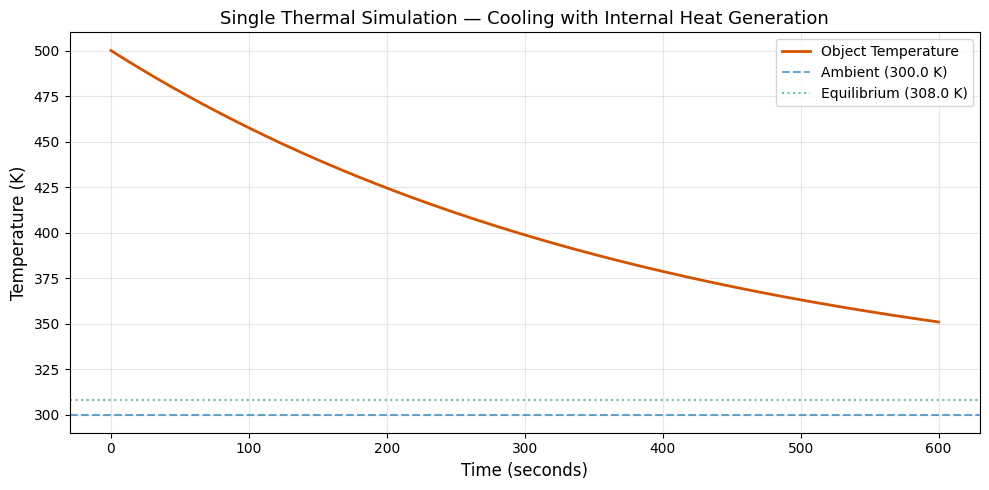

In [4]:
# Visualize a single simulation run
def plot_single_simulation(params):
    T0 = params['initial_temp']
    T_amb = params['ambient_temp']
    m = params['mass']
    cp = params['specific_heat']
    h = params['heat_transfer_coeff']
    A = params['surface_area']
    Q_gen = params['heat_generation']
    duration = params['sim_duration']

    t_span = np.linspace(0, duration, 500)
    solution = odeint(thermal_ode, T0, t_span,
                      args=(Q_gen, m, cp, h, A, T_amb))
    temp_profile = solution.flatten()

    T_eq = T_amb + Q_gen / (h * A) if h * A > 0 else T0

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(t_span, temp_profile, color='#d35400', linewidth=2, label='Object Temperature')
    ax.axhline(y=T_amb, color='#2980b9', linestyle='--', alpha=0.7, label=f'Ambient ({T_amb} K)')
    ax.axhline(y=T_eq, color='#27ae60', linestyle=':', alpha=0.7, label=f'Equilibrium ({T_eq:.1f} K)')

    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('Temperature (K)', fontsize=12)
    ax.set_title('Single Thermal Simulation — Cooling with Internal Heat Generation', fontsize=13)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_single_simulation(test_params)

---
## Step 5: Generate 1000 Simulations

We use Latin Hypercube Sampling (LHS) for better coverage of the parameter space compared to pure random sampling. LHS ensures each parameter range is evenly sampled, reducing gaps and clusters.

In [5]:
from scipy.stats import qmc

NUM_SIMULATIONS = 1000
np.random.seed(42)  # For reproducibility

# Use Latin Hypercube Sampling for better space coverage
param_names = list(param_bounds.keys())
n_params = len(param_names)

sampler = qmc.LatinHypercube(d=n_params, seed=42)
lhs_samples = sampler.random(n=NUM_SIMULATIONS)  # values in [0, 1]

# Scale samples to actual parameter ranges
lower_bounds = np.array([param_bounds[p]['lower'] for p in param_names])
upper_bounds = np.array([param_bounds[p]['upper'] for p in param_names])
scaled_samples = qmc.scale(lhs_samples, lower_bounds, upper_bounds)

print(f"Generated {NUM_SIMULATIONS} parameter sets using Latin Hypercube Sampling.")
print(f"Parameter space dimensions: {n_params}")
print(f"Sample shape: {scaled_samples.shape}")

Generated 1000 parameter sets using Latin Hypercube Sampling.
Parameter space dimensions: 8
Sample shape: (1000, 8)


In [6]:
# Run all 1000 simulations
results_list = []
start_time = time.time()

for i in range(NUM_SIMULATIONS):
    # Build parameter dictionary for this run
    params = {}
    for j, name in enumerate(param_names):
        params[name] = scaled_samples[i, j]

    # Run the simulation
    result = run_single_simulation(params)
    results_list.append(result)

    # Progress update every 200 simulations
    if (i + 1) % 200 == 0:
        elapsed = time.time() - start_time
        print(f"  Completed {i+1}/{NUM_SIMULATIONS} simulations ({elapsed:.1f}s elapsed)")

total_time = time.time() - start_time
print(f"\nAll {NUM_SIMULATIONS} simulations finished in {total_time:.2f} seconds.")
print(f"Average time per simulation: {total_time/NUM_SIMULATIONS*1000:.2f} ms")

  Completed 200/1000 simulations (0.2s elapsed)
  Completed 400/1000 simulations (0.3s elapsed)
  Completed 600/1000 simulations (0.5s elapsed)
  Completed 800/1000 simulations (0.6s elapsed)
  Completed 1000/1000 simulations (0.7s elapsed)

All 1000 simulations finished in 0.73 seconds.
Average time per simulation: 0.73 ms


In [7]:
# Convert results to a DataFrame
df = pd.DataFrame(results_list)

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:\n{list(df.columns)}")
print(f"\nFirst 5 rows:")
df.head()

Dataset shape: (1000, 16)

Column names:
['initial_temp', 'ambient_temp', 'mass', 'specific_heat', 'heat_transfer_coeff', 'surface_area', 'heat_generation', 'sim_duration', 'final_temp', 'max_temp', 'min_temp', 'temp_change', 'avg_temp', 'avg_cooling_rate', 'time_constant', 'equilibrium_temp']

First 5 rows:


,initial_temp,ambient_temp,mass,specific_heat,heat_transfer_coeff,surface_area,heat_generation,sim_duration,final_temp,max_temp,min_temp,temp_change,avg_temp,avg_cooling_rate,time_constant,equilibrium_temp
0,469.556511,313.142445,0.502493,342.311842,50.591053,0.095597,34.211943,2368.837332,320.216354,469.556511,320.216353,-149.340157,322.606733,-0.063044,37.977352,320.216354
1,531.217972,284.421985,3.116583,273.551265,11.683833,0.468408,0.927829,3131.915575,284.591520,531.217972,284.591520,-246.626452,297.082248,-0.078746,156.909598,284.591519
2,452.361354,317.077447,2.423445,637.057835,94.797982,0.065710,34.601465,2283.498351,322.645166,452.361354,322.645166,-129.716188,336.813419,-0.056806,247.112046,322.632231
3,519.055404,282.912214,2.709413,678.069337,88.490342,0.232362,10.762762,1302.655016,283.435760,519.055404,283.435760,-235.619644,299.801184,-0.180876,88.758057,283.435650
4,362.418544,316.945182,3.508099,472.167370,31.397657,0.335425,9.088655,3540.988858,317.808175,362.418544,317.808175,-44.610369,319.830626,-0.012598,156.115741,317.808175


In [8]:
# Statistical summary of the generated dataset
print("=" * 70)
print("STATISTICAL SUMMARY OF GENERATED DATASET")
print("=" * 70)
df.describe().round(3)

STATISTICAL SUMMARY OF GENERATED DATASET


,initial_temp,ambient_temp,mass,specific_heat,heat_transfer_coeff,surface_area,heat_generation,sim_duration,final_temp,max_temp,min_temp,temp_change,avg_temp,avg_cooling_rate,time_constant,equilibrium_temp
count,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000
mean,475.003,300.000,2.550,550.000,52.500,0.253,25.000,1830.052,318.509,475.007,318.505,-156.494,337.099,-0.159,215.558,307.174
std,72.204,11.553,1.415,202.187,27.438,0.143,14.442,1022.417,42.285,72.198,42.280,76.460,51.480,0.248,288.292,21.914
min,350.061,280.021,0.105,200.032,5.068,0.005,0.023,63.171,280.587,350.061,280.587,-313.892,280.998,-3.595,1.783,280.587
25%,412.625,290.021,1.325,375.031,28.759,0.129,12.505,947.092,296.512,412.625,296.512,-219.951,306.406,-0.165,47.630,294.625
50%,474.946,300.011,2.548,549.931,52.500,0.253,24.988,1830.210,308.363,474.946,308.363,-154.075,320.636,-0.088,104.874,305.507
75%,537.502,309.999,3.775,725.078,76.201,0.376,37.497,2714.087,320.135,537.502,320.135,-91.204,346.243,-0.052,247.034,315.396
max,599.957,319.980,4.996,899.499,99.959,0.500,49.997,3597.997,583.802,599.957,583.802,2.237,584.294,0.002,1824.276,580.486


---
## Exploratory Data Analysis

Before jumping into ML, let's understand what the simulation data looks like.

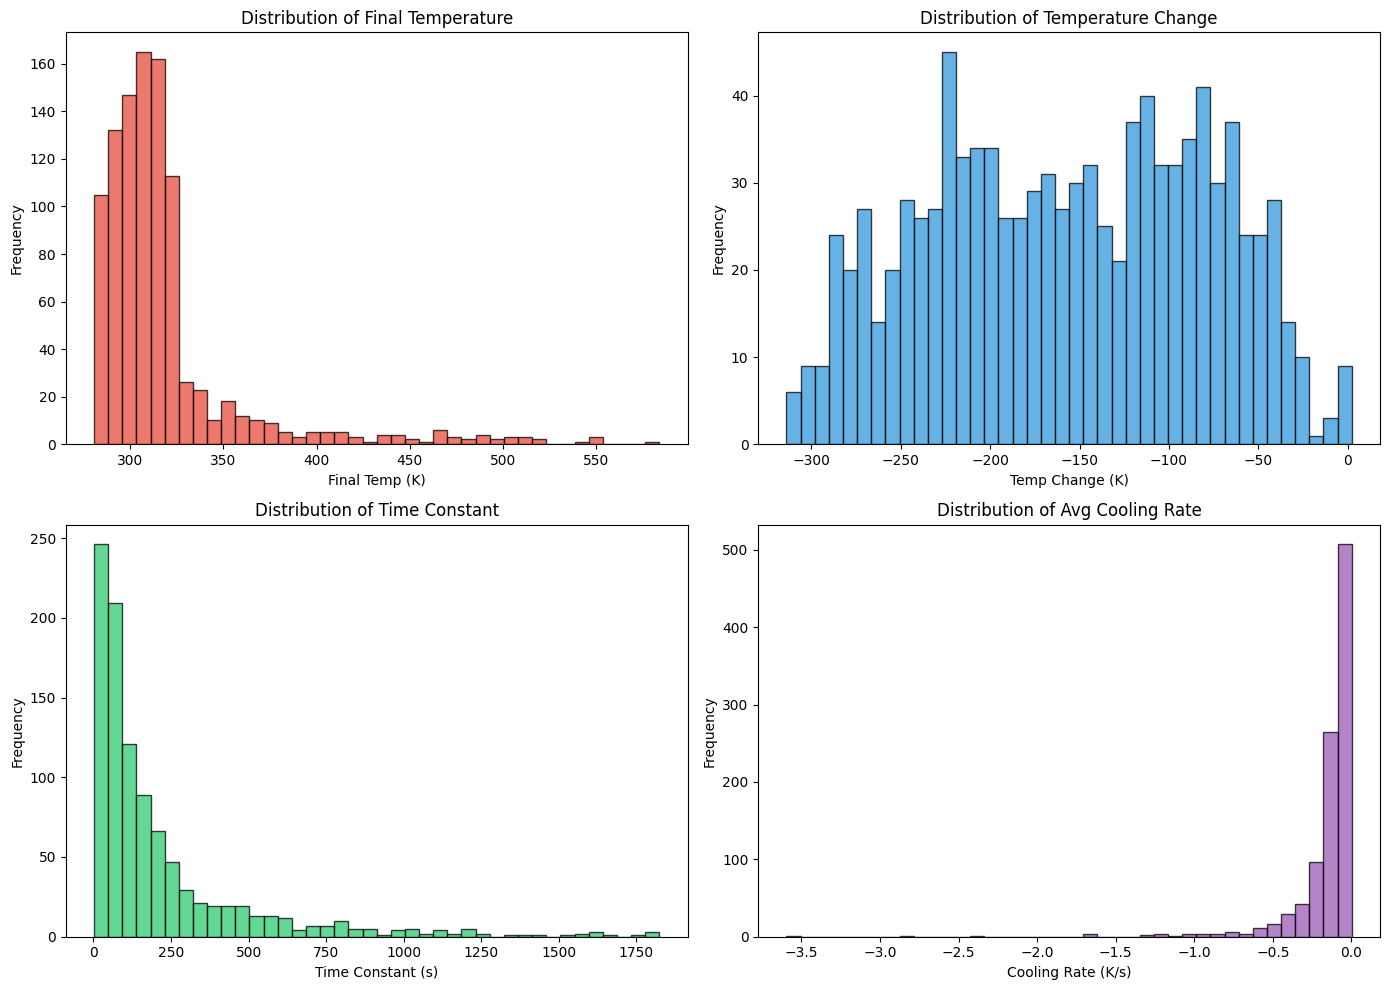

In [9]:
# Distribution of the target variable (final temperature)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Final temperature distribution
axes[0, 0].hist(df['final_temp'], bins=40, color='#e74c3c', alpha=0.75, edgecolor='black')
axes[0, 0].set_title('Distribution of Final Temperature', fontsize=12)
axes[0, 0].set_xlabel('Final Temp (K)')
axes[0, 0].set_ylabel('Frequency')

# Temperature change distribution
axes[0, 1].hist(df['temp_change'], bins=40, color='#3498db', alpha=0.75, edgecolor='black')
axes[0, 1].set_title('Distribution of Temperature Change', fontsize=12)
axes[0, 1].set_xlabel('Temp Change (K)')
axes[0, 1].set_ylabel('Frequency')

# Time constant distribution
axes[1, 0].hist(df['time_constant'], bins=40, color='#2ecc71', alpha=0.75, edgecolor='black')
axes[1, 0].set_title('Distribution of Time Constant', fontsize=12)
axes[1, 0].set_xlabel('Time Constant (s)')
axes[1, 0].set_ylabel('Frequency')

# Cooling rate distribution
axes[1, 1].hist(df['avg_cooling_rate'], bins=40, color='#9b59b6', alpha=0.75, edgecolor='black')
axes[1, 1].set_title('Distribution of Avg Cooling Rate', fontsize=12)
axes[1, 1].set_xlabel('Cooling Rate (K/s)')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

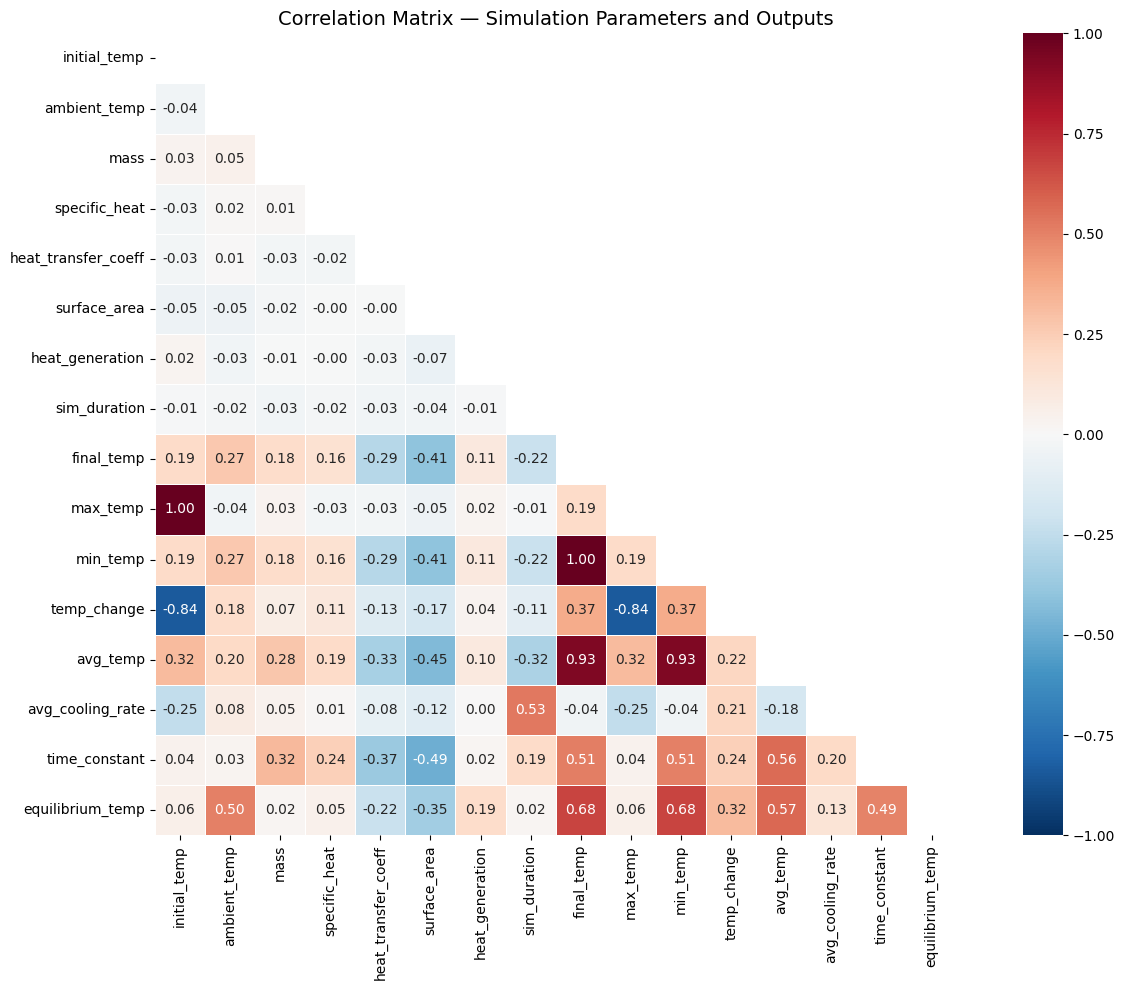

In [10]:
# Correlation heatmap
fig, ax = plt.subplots(figsize=(14, 10))
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix, mask=mask, annot=True, fmt='.2f',
    cmap='RdBu_r', center=0, vmin=-1, vmax=1,
    square=True, linewidths=0.5, ax=ax
)
ax.set_title('Correlation Matrix — Simulation Parameters and Outputs', fontsize=14)
plt.tight_layout()
plt.show()

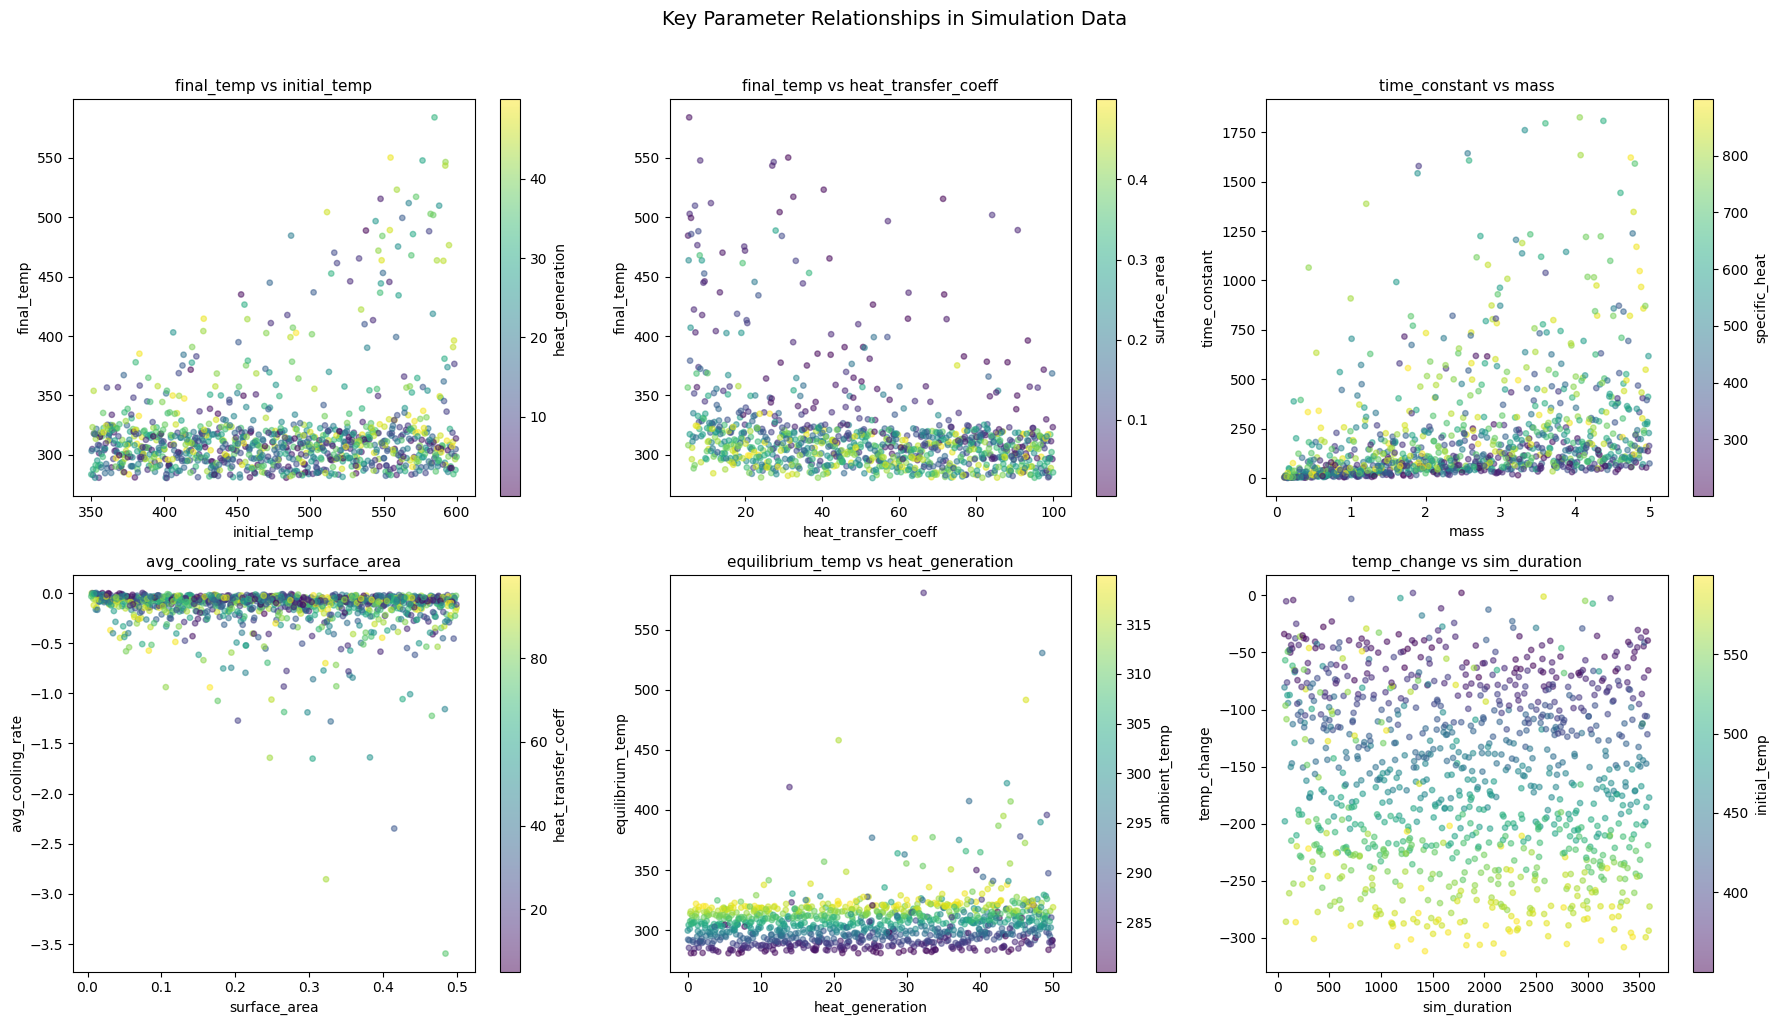

In [11]:
# Scatter plots: key relationships
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

scatter_pairs = [
    ('initial_temp', 'final_temp', 'heat_generation'),
    ('heat_transfer_coeff', 'final_temp', 'surface_area'),
    ('mass', 'time_constant', 'specific_heat'),
    ('surface_area', 'avg_cooling_rate', 'heat_transfer_coeff'),
    ('heat_generation', 'equilibrium_temp', 'ambient_temp'),
    ('sim_duration', 'temp_change', 'initial_temp'),
]

for idx, (x_col, y_col, color_col) in enumerate(scatter_pairs):
    row, col = idx // 3, idx % 3
    sc = axes[row, col].scatter(
        df[x_col], df[y_col], c=df[color_col],
        cmap='viridis', alpha=0.5, s=15
    )
    axes[row, col].set_xlabel(x_col)
    axes[row, col].set_ylabel(y_col)
    axes[row, col].set_title(f'{y_col} vs {x_col}', fontsize=11)
    plt.colorbar(sc, ax=axes[row, col], label=color_col)

plt.suptitle('Key Parameter Relationships in Simulation Data', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---
## Step 6: ML Model Comparison



In [12]:
# Prepare features and target
feature_cols = [
    'initial_temp', 'ambient_temp', 'mass', 'specific_heat',
    'heat_transfer_coeff', 'surface_area', 'heat_generation', 'sim_duration'
]
target_col = 'final_temp'

X = df[feature_cols].values
y = df[target_col].values

# 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features for models that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size:     {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Target variable: {target_col}")

Training set size: 800
Test set size:     200
Number of features: 8
Target variable: final_temp


In [13]:
# Define all models
models = {
    'Linear Regression': (LinearRegression(), False),
    'Ridge Regression': (Ridge(alpha=1.0, random_state=42), False),
    'Lasso Regression': (Lasso(alpha=0.1, random_state=42, max_iter=5000), False),
    'ElasticNet': (ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=5000), False),
    'K-Nearest Neighbors': (KNeighborsRegressor(n_neighbors=7), True),
    'Decision Tree': (DecisionTreeRegressor(max_depth=15, random_state=42), False),
    'Random Forest': (RandomForestRegressor(n_estimators=150, max_depth=20, random_state=42, n_jobs=-1), False),
    'Gradient Boosting': (GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42), False),
    'AdaBoost': (AdaBoostRegressor(n_estimators=100, learning_rate=0.5, random_state=42), False),
    'SVR (RBF Kernel)': (SVR(kernel='rbf', C=100, gamma='scale'), True),
}

print(f"Total models to evaluate: {len(models)}")

Total models to evaluate: 10


In [14]:
# Train and evaluate each model
results = []

for name, (model, needs_scaling) in models.items():
    print(f"Training: {name}...", end=" ")

    # Choose scaled or raw data
    Xtr = X_train_scaled if needs_scaling else X_train
    Xte = X_test_scaled if needs_scaling else X_test

    # Train
    t_start = time.time()
    model.fit(Xtr, y_train)
    train_time = time.time() - t_start

    # Predict
    y_pred = model.predict(Xte)

    # Evaluate
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100

    # Cross-validation (5-fold)
    Xfull = scaler.transform(X) if needs_scaling else X
    cv_scores = cross_val_score(model, Xfull, y, cv=5, scoring='r2')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    results.append({
        'Model': name,
        'R² Score': round(r2, 5),
        'MAE (K)': round(mae, 3),
        'RMSE (K)': round(rmse, 3),
        'MAPE (%)': round(mape, 3),
        'CV R² (mean)': round(cv_mean, 5),
        'CV R² (std)': round(cv_std, 5),
        'Train Time (s)': round(train_time, 4),
    })

    print(f"R²={r2:.4f}, RMSE={rmse:.2f} K, Time={train_time:.3f}s")

print("\nAll models trained and evaluated.")

Training: Linear Regression... R²=0.4549, RMSE=33.56 K, Time=0.020s
Training: Ridge Regression... R²=0.4528, RMSE=33.63 K, Time=0.002s
Training: Lasso Regression... R²=0.4532, RMSE=33.61 K, Time=0.001s
Training: ElasticNet... R²=0.3666, RMSE=36.17 K, Time=0.001s
Training: K-Nearest Neighbors... R²=0.5773, RMSE=29.55 K, Time=0.002s
Training: Decision Tree... R²=0.6120, RMSE=28.31 K, Time=0.010s
Training: Random Forest... R²=0.8054, RMSE=20.05 K, Time=0.866s
Training: Gradient Boosting... R²=0.8690, RMSE=16.45 K, Time=1.346s
Training: AdaBoost... R²=0.7006, RMSE=24.87 K, Time=0.259s
Training: SVR (RBF Kernel)... R²=0.7318, RMSE=23.54 K, Time=0.162s

All models trained and evaluated.


In [15]:
# Create the comparison table
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('R² Score', ascending=False).reset_index(drop=True)
results_df.index = results_df.index + 1  # Start ranking from 1
results_df.index.name = 'Rank'

print("=" * 110)
print("MODEL COMPARISON TABLE — Predicting Final Temperature from Simulation Parameters")
print("=" * 110)
print(results_df.to_string())
print("=" * 110)

best_model_name = results_df.iloc[0]['Model']
best_r2 = results_df.iloc[0]['R² Score']
print(f"\n>>> BEST MODEL: {best_model_name} with R² = {best_r2} <<<")

MODEL COMPARISON TABLE — Predicting Final Temperature from Simulation Parameters
                    Model  R² Score  MAE (K)  RMSE (K)  MAPE (%)  CV R² (mean)  CV R² (std)  Train Time (s)
Rank                                                                                                       
1       Gradient Boosting   0.86902    7.766    16.451     2.097       0.72743      0.04808          1.3459
2           Random Forest   0.80545    9.323    20.049     2.526       0.70382      0.03552          0.8663
3        SVR (RBF Kernel)   0.73180   10.333    23.540     2.719       0.70394      0.07535          0.1624
4                AdaBoost   0.70064   19.865    24.870     6.089       0.55029      0.09926          0.2586
5           Decision Tree   0.61202   12.963    28.313     3.630       0.34865      0.15983          0.0104
6     K-Nearest Neighbors   0.57726   15.776    29.554     4.310       0.52745      0.07205          0.0019
7       Linear Regression   0.45491   22.590    33.559 

---
## Results Visualization

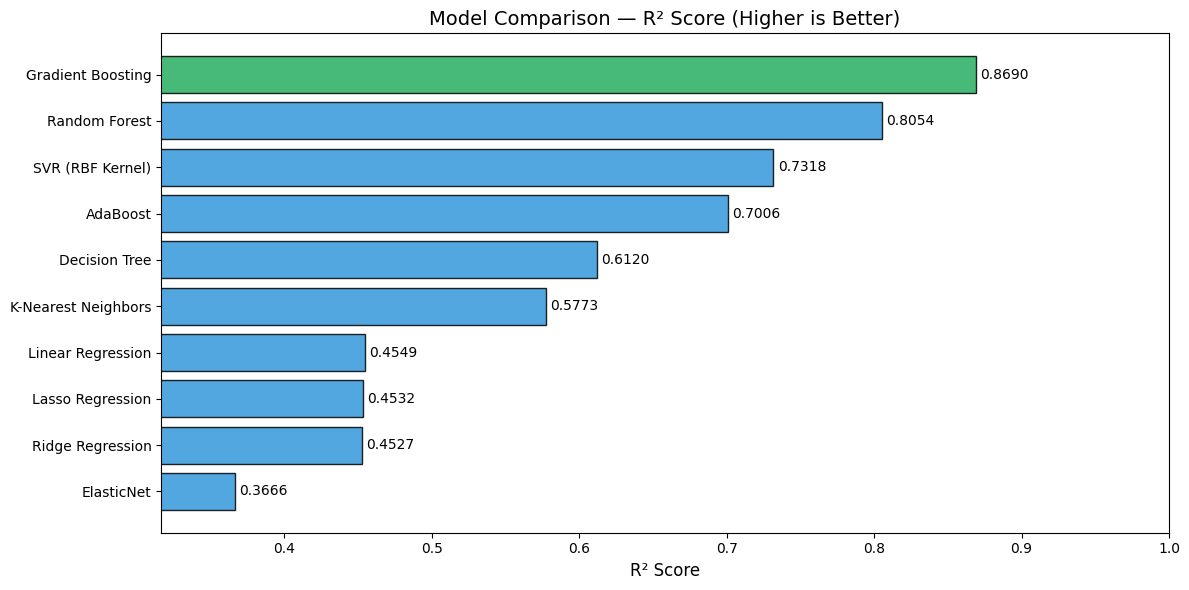

In [16]:
# Bar chart comparison of R² scores
fig, ax = plt.subplots(figsize=(12, 6))

model_names = results_df['Model'].tolist()
r2_scores = results_df['R² Score'].tolist()

colors = ['#27ae60' if i == 0 else '#3498db' for i in range(len(model_names))]
bars = ax.barh(model_names[::-1], r2_scores[::-1], color=colors[::-1], edgecolor='black', alpha=0.85)

ax.set_xlabel('R² Score', fontsize=12)
ax.set_title('Model Comparison — R² Score (Higher is Better)', fontsize=14)
ax.set_xlim(min(r2_scores) - 0.05, 1.0)

for bar, score in zip(bars, r2_scores[::-1]):
    ax.text(bar.get_width() + 0.003, bar.get_y() + bar.get_height()/2,
            f'{score:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

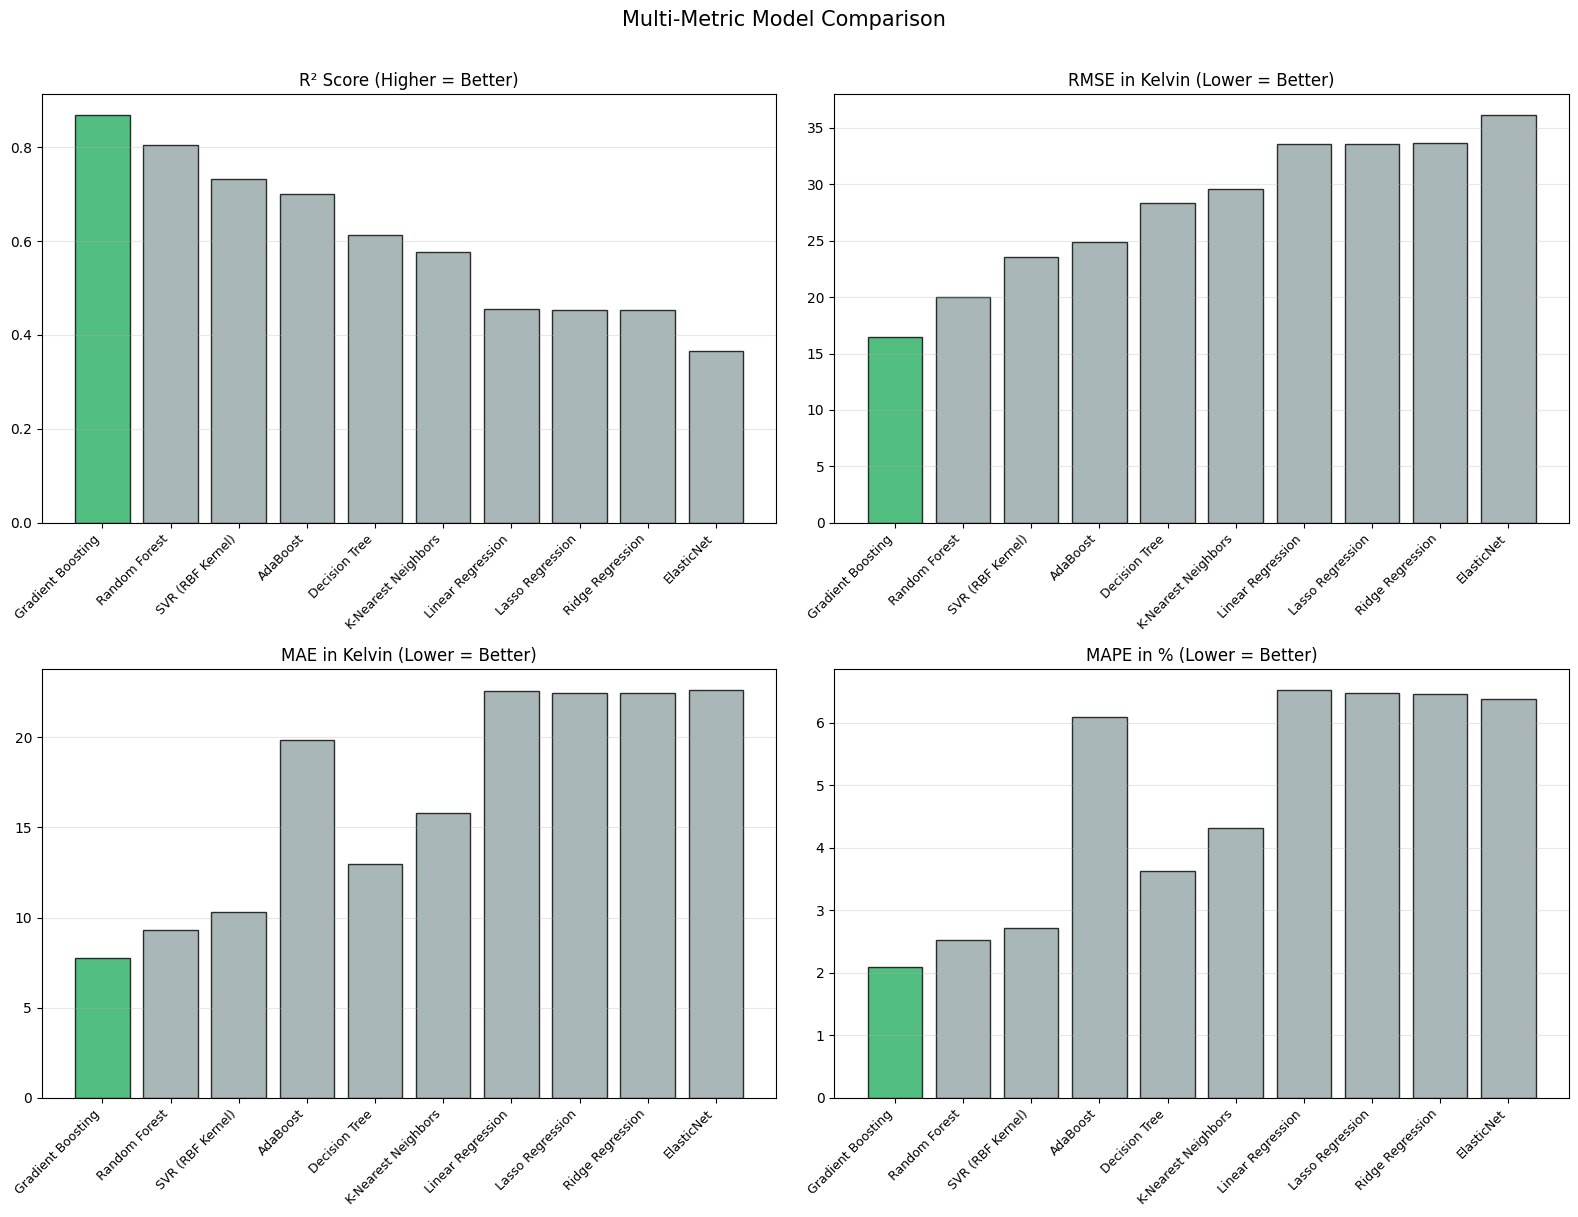

In [17]:
# Multi-metric comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_to_plot = [
    ('R² Score', 'R² Score (Higher = Better)', True),
    ('RMSE (K)', 'RMSE in Kelvin (Lower = Better)', False),
    ('MAE (K)', 'MAE in Kelvin (Lower = Better)', False),
    ('MAPE (%)', 'MAPE in % (Lower = Better)', False),
]

for idx, (col, title, higher_better) in enumerate(metrics_to_plot):
    row, col_idx = idx // 2, idx % 2
    ax = axes[row, col_idx]

    vals = results_df[col].tolist()
    names = results_df['Model'].tolist()

    if higher_better:
        best_idx = np.argmax(vals)
    else:
        best_idx = np.argmin(vals)

    bar_colors = ['#27ae60' if i == best_idx else '#95a5a6' for i in range(len(names))]
    ax.bar(range(len(names)), vals, color=bar_colors, edgecolor='black', alpha=0.8)
    ax.set_xticks(range(len(names)))
    ax.set_xticklabels(names, rotation=45, ha='right', fontsize=9)
    ax.set_title(title, fontsize=12)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Multi-Metric Model Comparison', fontsize=15, y=1.01)
plt.tight_layout()
plt.show()

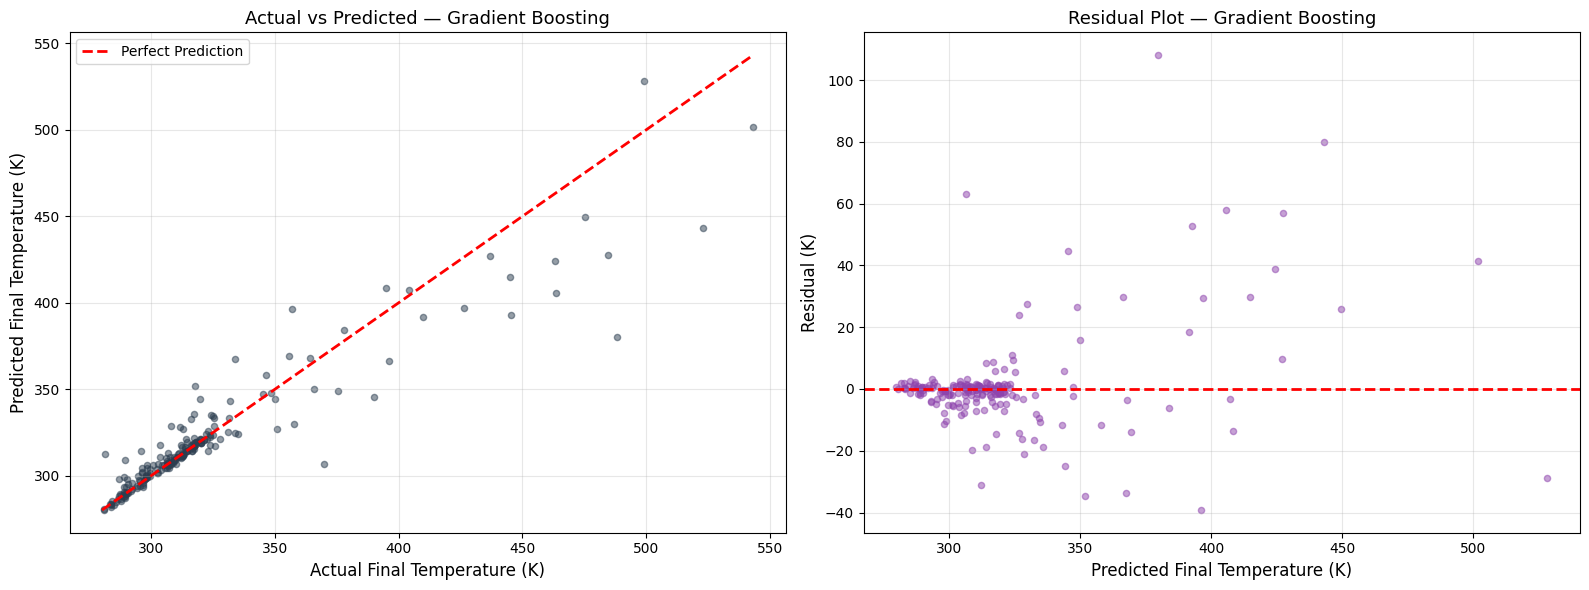

Residual Statistics for Gradient Boosting:
  Mean residual:   1.3928 K
  Std of residuals: 16.3916 K
  Max abs residual: 108.1426 K


In [18]:
# Actual vs Predicted for the best model
best_model_info = models[best_model_name]
best_model_obj = best_model_info[0]
uses_scaling = best_model_info[1]

Xte_final = X_test_scaled if uses_scaling else X_test
y_pred_best = best_model_obj.predict(Xte_final)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter: actual vs predicted
axes[0].scatter(y_test, y_pred_best, alpha=0.5, s=20, color='#2c3e50')
min_val = min(y_test.min(), y_pred_best.min())
max_val = max(y_test.max(), y_pred_best.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Final Temperature (K)', fontsize=12)
axes[0].set_ylabel('Predicted Final Temperature (K)', fontsize=12)
axes[0].set_title(f'Actual vs Predicted — {best_model_name}', fontsize=13)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Residuals
residuals = y_test - y_pred_best
axes[1].scatter(y_pred_best, residuals, alpha=0.5, s=20, color='#8e44ad')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Final Temperature (K)', fontsize=12)
axes[1].set_ylabel('Residual (K)', fontsize=12)
axes[1].set_title(f'Residual Plot — {best_model_name}', fontsize=13)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Residual Statistics for {best_model_name}:")
print(f"  Mean residual:   {residuals.mean():.4f} K")
print(f"  Std of residuals: {residuals.std():.4f} K")
print(f"  Max abs residual: {np.abs(residuals).max():.4f} K")

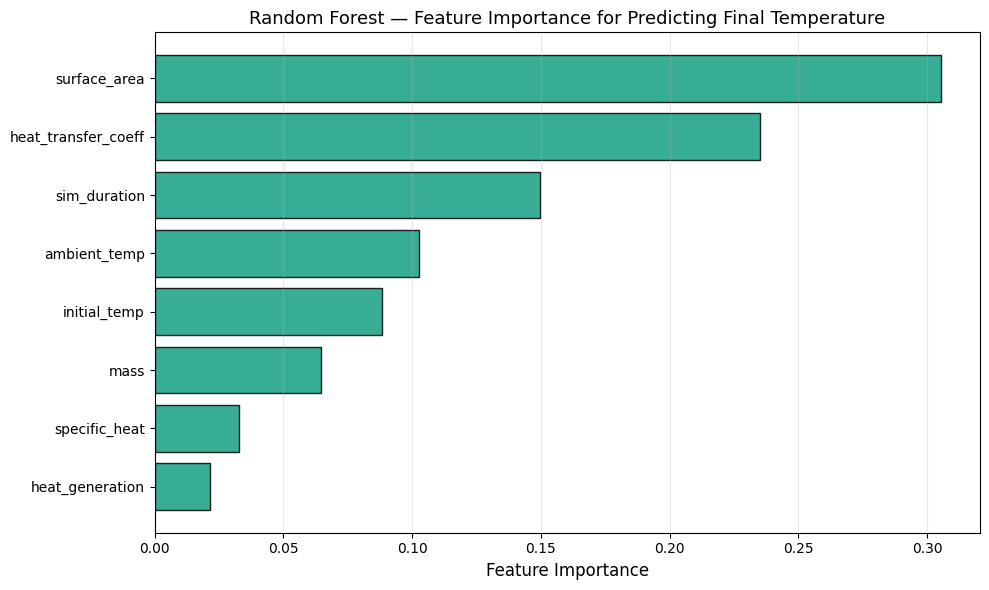

In [19]:
# Feature importance (for tree-based best model)
# We'll show Random Forest importances regardless, as they're always informative
rf_model = models['Random Forest'][0]
importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(
    [feature_cols[i] for i in sorted_idx],
    importances[sorted_idx],
    color='#16a085', edgecolor='black', alpha=0.85
)
ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_title('Random Forest — Feature Importance for Predicting Final Temperature', fontsize=13)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

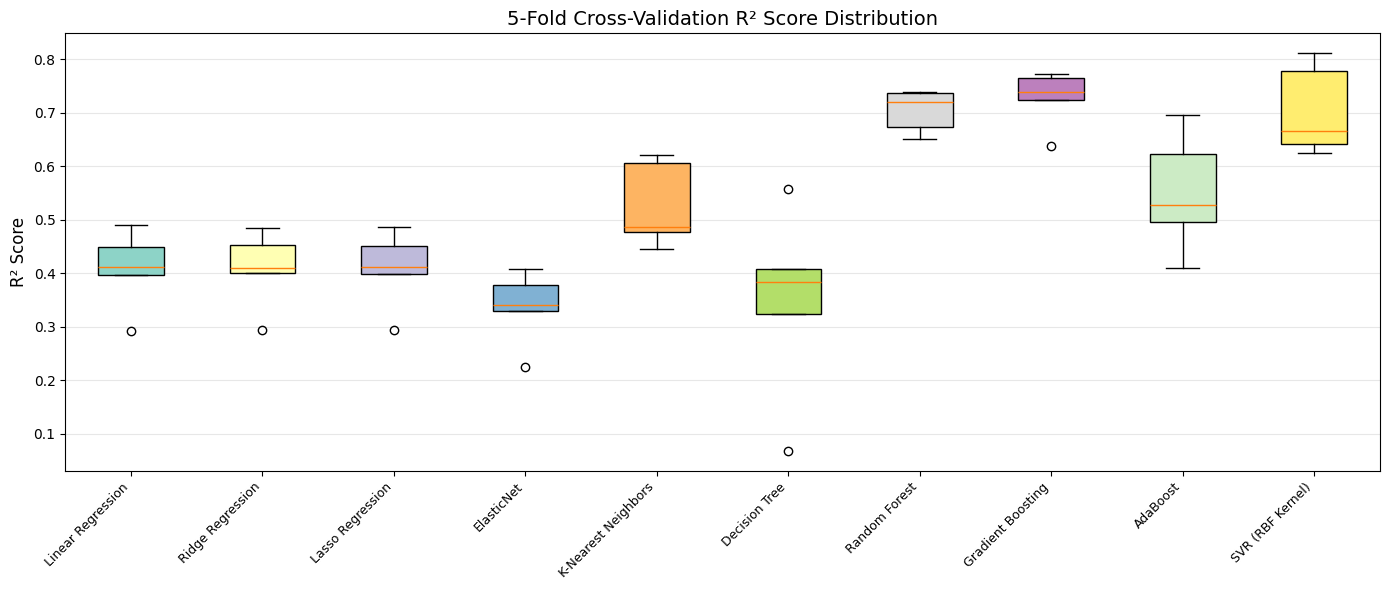

In [20]:
# Cross-validation boxplot
fig, ax = plt.subplots(figsize=(14, 6))

cv_data = []
cv_labels = []

for name, (model, needs_scaling) in models.items():
    Xfull = scaler.transform(X) if needs_scaling else X
    scores = cross_val_score(model, Xfull, y, cv=5, scoring='r2')
    cv_data.append(scores)
    cv_labels.append(name)

bp = ax.boxplot(cv_data, labels=cv_labels, patch_artist=True, vert=True)

colors_bp = plt.cm.Set3(np.linspace(0, 1, len(cv_labels)))
for patch, color in zip(bp['boxes'], colors_bp):
    patch.set_facecolor(color)

ax.set_ylabel('R² Score', fontsize=12)
ax.set_title('5-Fold Cross-Validation R² Score Distribution', fontsize=14)
ax.set_xticklabels(cv_labels, rotation=45, ha='right', fontsize=9)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

---
## Save the Dataset

In [21]:
# Save the simulation dataset to CSV
df.to_csv('thermal_simulation_dataset.csv', index=False)
print("Dataset saved as 'thermal_simulation_dataset.csv'")
print(f"Total rows: {len(df)}, Total columns: {len(df.columns)}")

Dataset saved as 'thermal_simulation_dataset.csv'
Total rows: 1000, Total columns: 16
